## Product Categorization

### Multi-Class Text Classification of products based on their description


The aim of the project is multi-class text classification of make-up products based on their description and categories. Based on given text as an input, we have predicted what would be the category. We have five types of categories corresponding to different makeup products. We used different machine learning algorithms to get more accurate predictions and choose the most accurate one for our issue. The following classification algorithms have been used: Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boosting as well. To analysis we used python and their libraries: pandas, matplotlib, NLTK and scikit-learn.

**Dataset**

The dataset comes from http://makeup-api.herokuapp.com/ and has been obtained by an API.

The dataset contains the real descriptions about makeup products. Each description has been labeled with a specific product, therefore, this is a supervised text classification problem. 

Attributes:

- product_type - category of makeup product.
- description - description of makeup product.

### Importing packages and loading data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report

import pickle
from joblib import dump, load

For our analysis we use data with only two variables: product_type and description.

In [2]:
df = pd.read_csv('data\products_description.csv', header=0,index_col=0)
df.head()

,product_type,description
0,lip_liner,Lippie Pencil A long-wearing and high-intensit...
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,..."
3,foundation,"Developed for the Selfie Age, our buildable fu..."
4,lipstick,All of our products are free from lead and hea...


Firts observations:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 930
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_type  906 non-null    object
 1   description   906 non-null    object
dtypes: object(2)
memory usage: 21.2+ KB


Shape of data:

In [4]:
df.shape

(906, 2)

Checking the missing values in data:

In [5]:
df.isnull().sum()

product_type    0
description     0
dtype: int64

Example description:

In [6]:
df['description'][3]

'Developed for the Selfie Age, our buildable full coverage, natural matte foundation delivers flawless looking skin from day-to-night. The oil-free, lightweight formula blends smoothly and is easily customizable to create the coverage you want. Build it up or sheer it out, it was developed with innovative soft-blurring pigments to deliver true color while looking and feeling natural. The lockable pump is easy to use and keeps your routine mess-free! As always, 100% cruelty-free and vegan.'

## Data Cleaning

**Data type change:**

In [7]:
df['description'] = df['description'].astype(str)

In [8]:
print(df['description'].apply(lambda x: len(x.split(' '))).sum())

94257


We have 94 257 words in the data.

In [10]:
df.product_type.unique()

array(['lip_liner', 'lipstick', 'foundation', 'eyeliner', 'eyeshadow',
       'blush', 'bronzer', 'mascara', 'eyebrow', 'nail_polish'],
      dtype=object)

#### Grouping data to a smaller number of categories:

We have 10 unique products and  some of them  we can group to one category. We can link 'eyeliner', 'eyeshadow', 'mascara', 'eyebrow' to one group called as 'eye_makeup'. We can apply the same to 'blush' and 'bronzer' as 'contour' and 'lipstick' with 'lip_liner' to 'lipstick'. 

In [11]:
df.product_type.value_counts()

foundation     159
lipstick       148
eyeliner       145
mascara         91
eyeshadow       86
blush           75
bronzer         69
nail_polish     60
eyebrow         45
lip_liner       28
Name: product_type, dtype: int64

In [12]:
def grouping_data(df):
    df.loc[df['product_type'].isin(['lipstick','lip_liner']),'product_type'] = 'lipstick'
    df.loc[df['product_type'].isin(['blush','bronzer']),'product_type'] = 'contour'
    df.loc[df['product_type'].isin(['eyeliner','eyeshadow','mascara','eyebrow']),'product_type'] = 'eye_makeup'
    return df

In [13]:
df = grouping_data(df)

We have received a five group of categories:  Eye makeup, Lipstick, Foundation, Contour and Nail polish.

**Lenght of characters:**

In [14]:
df['length'] = df['description'].apply(len)
df.head()

,product_type,description,length
0,lipstick,Lippie Pencil A long-wearing and high-intensit...,232
1,lipstick,Blotted Lip Sheer matte lipstick that creates ...,146
2,lipstick,"Lippie Stix Formula contains Vitamin E, Mango,...",188
3,foundation,"Developed for the Selfie Age, our buildable fu...",492
4,lipstick,All of our products are free from lead and hea...,357


## Data analysis

We check proportion product_type variable:

In [15]:
df.product_type.value_counts()

eye_makeup     367
lipstick       176
foundation     159
contour        144
nail_polish     60
Name: product_type, dtype: int64

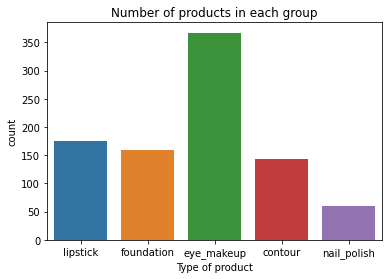

In [18]:
sns.countplot(x='product_type',data=df)
plt.xlabel('Type of product')
plt.title('Number of products in each group');

One can see that products from the eye makeup group is the largest one. It is over two times larger than in the lipstick group.

**The length of characters in all categories:**

Histogram of description length:

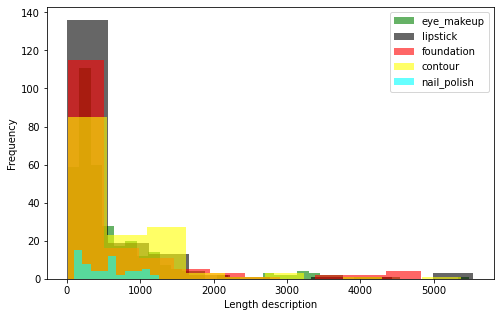

In [23]:
plt.figure(figsize=(8, 5))
df[df.product_type == 'eye_makeup'].length.plot(bins=35, kind='hist', color='green', label='eye_makeup', alpha=0.6)
df[df.product_type == 'lipstick'].length.plot(kind='hist', color='black', label='lipstick', alpha=0.6)
df[df.product_type == 'foundation'].length.plot(kind='hist', color='red', label='foundation', alpha=0.6)
df[df.product_type == 'contour'].length.plot(kind='hist', color='yellow', label='contour', alpha=0.6)
df[df.product_type == 'nail_polish'].length.plot(kind='hist', color='aqua', label='nail_polish', alpha=0.6)
plt.legend()
plt.xlabel("Length description");

**The length of characters divided into categories:**

Histogram of description length of each categories:


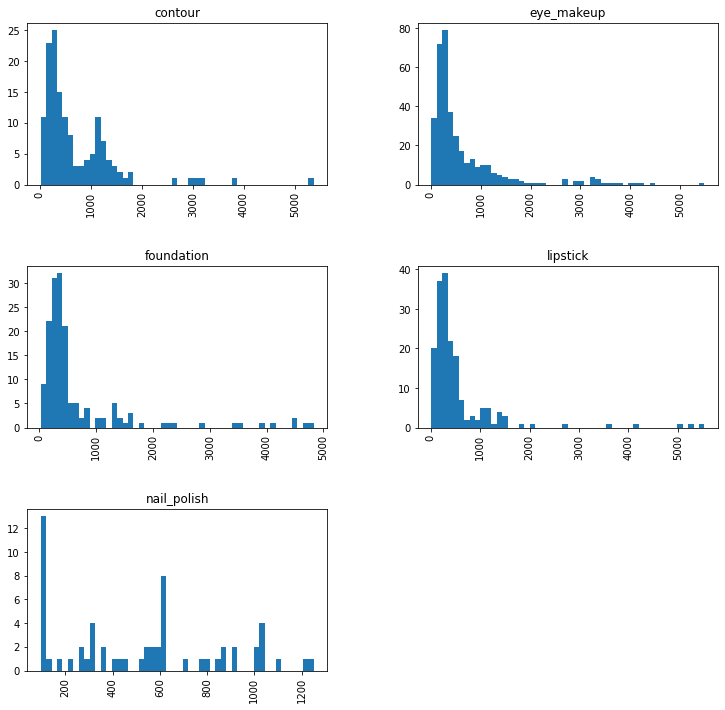

In [24]:
df.hist(column='length', by='product_type', bins=50,figsize=(12,12));

The largest description has almost 200 characters, some of them are very short.

## Text Pre-processing

In this step we have to remove punctuation, stop words, bad characters and so on. The second step is aimed to convertion all of the words to lower case and then stemmed them using the Porter Stemmer and Lemmatizer in the NLTK package.

**Stemming** operation bundles together words of same root. E.g. stem operation bundles “fishing”,  and “fished” into a common "fish".

**Lemmatizing** (Lemmatising) is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form

The function to clean text, remove stop words and apply stemming operation for each line of text:

In [26]:
stop = stopwords.words('english')
print(stop[::10])

porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [1]:
def preprocess_data(text):
    ''' The function to remove punctuation,
    stopwords and apply stemming'''
    
    words = re.sub("[^a-zA-Z]", " ", text)
    words = [word.lower() for word in text.split() if word.lower() not in stop]
#     words = [porter.stem(word) for word in words]
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]
#     return " ".join(lem_text)
    return " ".join(words)

Apply the function to each examples:

In [37]:
df['description'] = df['description'].apply(preprocess_data)

In [38]:
df['description'][2]

'lippi stix formula contain vitamin e, mango, avocado, shea butter ad comfort moisture. none lippi formula contain nasti ingredi like paraben sulfates.'

#### Pos Tagging

To get deeper insight into the way in which that word is used in speech, the Part of speech (POS) tagging method has been used. There are eight primary parts of speech and each of them have a corresponding tag. The NLTK libary has a method to perform POS tagging. 

The example of Pos Tagging on analyzed dataset is presented below: 

In [43]:
tokens = df['description'][0]

nltk.pos_tag(word_tokenize(tokens))

[('lippi', 'JJ'),
 ('pencil', 'NN'),
 ('long-wear', 'JJ'),
 ('high-intens', 'NNS'),
 ('lip', 'NN'),
 ('pencil', 'NN'),
 ('glide', 'NN'),
 ('easili', 'FW'),
 ('prevent', 'NN'),
 ('feathering', 'NN'),
 ('.', '.'),
 ('mani', 'NN'),
 ('lippi', 'JJ'),
 ('stix', 'NN'),
 ('coordin', 'NN'),
 ('lippi', 'NN'),
 ('pencil', 'NN'),
 ('design', 'NN'),
 ('compliment', 'NN'),
 ('perfectly', 'RB'),
 (',', ','),
 ('feel', 'VB'),
 ('free', 'JJ'),
 ('mix', 'NN'),
 ('match', 'NN'),
 ('!', '.')]

Here we see that and is CC, a coordinating conjunction; now and completely are RB, or adverbs; for is IN, a preposition; something is NN, a noun; and different is JJ, an adjective.



### Bag of words

To run machine learning algorithms we need to convert the text files into numerical feature vectors. We will use bag of words model for our analysis. In general we segment each text file into words  and count of times each word occurs in each document and finally assign each word an integer id. Each unique word in our dictionary will correspond to a feature (descriptive feature).

More precisely we will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized TF-IDF representation (tf-idf transformer). 



In [46]:

#### CountVectorizer 

vectorizer = CountVectorizer()
vectorizer.fit(df['description'])
vector = vectorizer.transform(df['description'])

In [47]:
print(vector.shape)
print(vector.toarray())

(906, 5514)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF
Term Frequency–Inverse Document Frequency

Extract the **tfidf** representation matrix of the text data:

In [48]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Data preparation

Now we split dataset into train and test dataset:

In [54]:
X = df['description']
y = df['product_type']

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.30, random_state=42)

In [55]:
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=30)

In [57]:
X_train.shape, X_test.shape,X_cv.shape, y_train.shape, y_test.shape, y_cv.shape

((634,), (136,), (136,), (634,), (136,), (136,))

## Build model

We use different machine learning algorithms to get more accurate predictions and choose the most accurate one for our issue. The used classification models are: Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boosting as well.

#### Pipeline

We build a pipeline. We can write less code and do all of the above, by building a pipeline as follows.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.

**Models**

Firstly we calculate each model separately. To evaluate our models we used accuracy score and classification report(precision, recall, F1-score). 

Accuracy is one of the most common classification evaluation metric, i.e. the number of correct predictions made as a ratio of total predictions. 

#### 1. Logistic Regression

In [68]:
model_log = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                      ('tfidf', TfidfTransformer()),
                      ('model',LogisticRegression()),
                     ])

model_log.fit(X_train, y_train)

y_cv = np.array(y_cv)
pred_cv = model_log.predict(X_cv)
ytest = np.array(y_test)
pred = model_log.predict(X_test)

In [69]:
print('accuracy %s' % accuracy_score(pred_cv, y_cv))
print(classification_report(y_cv, pred_cv))
# print('====================')
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9264705882352942
              precision    recall  f1-score   support

     contour       0.91      0.91      0.91        22
  eye_makeup       0.92      1.00      0.96        65
  foundation       1.00      0.85      0.92        26
    lipstick       0.88      0.83      0.86        18
 nail_polish       1.00      0.80      0.89         5

    accuracy                           0.93       136
   macro avg       0.94      0.88      0.91       136
weighted avg       0.93      0.93      0.93       136

accuracy 0.9264705882352942
              precision    recall  f1-score   support

     contour       0.89      0.94      0.92        18
  eye_makeup       0.88      1.00      0.93        50
  foundation       1.00      0.81      0.90        27
    lipstick       0.97      0.88      0.92        33
 nail_polish       1.00      1.00      1.00         8

    accuracy                           0.93       136
   macro avg       0.95      0.93      0.93       136
weighted avg       0.

**2. LinearSVC**

In [75]:
svc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',LinearSVC()),
               ])

svc.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = svc.predict(X_test)

In [76]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9632352941176471
              precision    recall  f1-score   support

     contour       0.94      0.94      0.94        18
  eye_makeup       0.94      1.00      0.97        50
  foundation       1.00      0.96      0.98        27
    lipstick       0.97      0.91      0.94        33
 nail_polish       1.00      1.00      1.00         8

    accuracy                           0.96       136
   macro avg       0.97      0.96      0.97       136
weighted avg       0.96      0.96      0.96       136



In [119]:
with open(r'models\svc_model.pkl','wb') as f:
    pickle.dump(svc,f)

#### 3. Naive Bayes Classifier 

In [77]:
nbc = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('model',MultinomialNB()),
               ])

nbc.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = nbc.predict(X_test)

In [78]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9191176470588235
              precision    recall  f1-score   support

     contour       0.86      1.00      0.92        18
  eye_makeup       0.86      1.00      0.93        50
  foundation       1.00      0.81      0.90        27
    lipstick       1.00      0.88      0.94        33
 nail_polish       1.00      0.75      0.86         8

    accuracy                           0.92       136
   macro avg       0.94      0.89      0.91       136
weighted avg       0.93      0.92      0.92       136



**4. Random Forest**

In [79]:
rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators=50)),
               ])

rf.fit(X_train, y_train)

ytest = np.array(y_test)
preds = rf.predict(X_test)

In [80]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9411764705882353
              precision    recall  f1-score   support

     contour       0.90      1.00      0.95        18
  eye_makeup       0.89      1.00      0.94        50
  foundation       1.00      0.81      0.90        27
    lipstick       1.00      0.91      0.95        33
 nail_polish       1.00      1.00      1.00         8

    accuracy                           0.94       136
   macro avg       0.96      0.94      0.95       136
weighted avg       0.95      0.94      0.94       136



In [112]:
with open(r'models\rf_model.pkl','wb') as f:
    pickle.dump(rf,f)

**5. Gradient Boosting**

In [81]:
model_gb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('gb', GradientBoostingClassifier(n_estimators=50)),
                    ])

model_gb.fit(X_train, y_train)

ytest = np.array(y_test)
predicted = model_gb.predict(X_test)

In [82]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.9117647058823529
              precision    recall  f1-score   support

     contour       0.95      1.00      0.97        18
  eye_makeup       0.85      1.00      0.92        50
  foundation       0.92      0.81      0.86        27
    lipstick       1.00      0.79      0.88        33
 nail_polish       1.00      1.00      1.00         8

    accuracy                           0.91       136
   macro avg       0.94      0.92      0.93       136
weighted avg       0.92      0.91      0.91       136



We can write a function to build and calculates our all models by using a pipeline as follows:

In [83]:
def get_models(X_train, X_test, y_train, y_test):
    models = pd.DataFrame()
    classifiers = [
        LogisticRegression(),
        LinearSVC(),
        MultinomialNB(),
        RandomForestClassifier(n_estimators=50),
        GradientBoostingClassifier(n_estimators=50), ]

    for classifier in classifiers:
        pipeline = Pipeline(steps=[('vect', CountVectorizer(
                               min_df=5, ngram_range=(1, 2))),
                                    ('tfidf', TfidfTransformer()),
                                    ('classifier', classifier)])
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        param_dict = {
                      'Model': classifier.__class__.__name__,
                      'Score': score
                     }
        models = models.append(pd.DataFrame(param_dict, index=[0]))

    models.reset_index(drop=True, inplace=True)
    print(models.sort_values(by='Score', ascending=False))

In [87]:
get_models(X_train, X_test, y_train, y_test)

C:\Users\HRITVI~1.PAT\AppData\Local\Temp/ipykernel_11248/593421024.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(pd.DataFrame(param_dict, index=[0]))
C:\Users\HRITVI~1.PAT\AppData\Local\Temp/ipykernel_11248/593421024.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(pd.DataFrame(param_dict, index=[0]))
C:\Users\HRITVI~1.PAT\AppData\Local\Temp/ipykernel_11248/593421024.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(pd.DataFrame(param_dict, index=[0]))
C:\Users\HRITVI~1.PAT\AppData\Local\Temp/ipykernel_11248/593421024.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

                        Model     Score
1                   LinearSVC  0.963235
0          LogisticRegression  0.926471
2               MultinomialNB  0.919118
3      RandomForestClassifier  0.911765
4  GradientBoostingClassifier  0.911765


C:\Users\HRITVI~1.PAT\AppData\Local\Temp/ipykernel_11248/593421024.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  models = models.append(pd.DataFrame(param_dict, index=[0]))


**Best model**

We have tested several different models and now, we check which one is the best:

In [88]:
log_acc = accuracy_score(pred, y_test)
svm_acc = accuracy_score(y_pred, y_test)
nb_acc = accuracy_score(pred_y, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(predicted, y_test)

In [91]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVC', 'Naive Bayes', 'Random Forest', 'Gradient Boosting'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc, gb_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SVC,0.963235
3,Random Forest,0.941176
0,Logistic Regression,0.926471
2,Naive Bayes,0.919118
4,Gradient Boosting,0.911765


From above analysis we see that the best model is SVC with accuracy score of 96%. 

### Predictions

We can see some predictions from our model on test example text (makeup description).

First we load our trained model:

In [113]:
with open(r'models\rf_model.pkl', 'rb') as f:
    rfmodel = load(f)

In [114]:
rfmodel

Pipeline(steps=[('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier(n_estimators=50))])

In [120]:
with open(r'models\svc_model.pkl', 'rb') as f:
    svcmodel = load(f)

In [121]:
svcmodel

Pipeline(steps=[('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

In [95]:
with open(r'models\text_model.pkl', 'rb') as f:
    model = load(f)

C:\Users\hritvik.patwa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\hritvik.patwa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\hritvik.patwa\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 

Example text (description of the real makeup product - mascara):

In [109]:
model

Pipeline(steps=[('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('model', LinearSVC())])

In [116]:
text = ["The immediate effect of lengthened and thickened eyelashes without splashing or smudging, perfectly resists high temperatures and humidity, so you can spend the day actively. Safe for sensitive eyes and people wearing contact lenses.",
       "Velvety, hydrating matte lipstick for everyday use, Offers a smooth, creamy texture that does not dry","Create a sculpted and defined look with the simple, easy to use Highlight & Contour Palette. Use the light shade to enhance and brighten up the face, and the dark shade to warm up the complexion. Available in 2 different smooth and blendable shades ."]
print(text)

['The immediate effect of lengthened and thickened eyelashes without splashing or smudging, perfectly resists high temperatures and humidity, so you can spend the day actively. Safe for sensitive eyes and people wearing contact lenses.', 'Velvety, hydrating matte lipstick for everyday use, Offers a smooth, creamy texture that does not dry', 'Create a sculpted and defined look with the simple, easy to use Highlight & Contour Palette. Use the light shade to enhance and brighten up the face, and the dark shade to warm up the complexion. Available in 2 different smooth and blendable shades .']


We can check the result and predicted class:

In [117]:
y.unique()

array(['lipstick', 'foundation', 'eye_makeup', 'contour', 'nail_polish'],
      dtype=object)

In [122]:
prediction = model.predict(text)
rf_pred = rf.predict(text)
svc_pred = svc.predict(text)
print(prediction)
print('============')
print(rf_pred)
print('============')
print(svc_pred)

['eye_makeup' 'lipstic' 'foundation']
['eye_makeup' 'lipstick' 'eye_makeup']
['eye_makeup' 'lipstick' 'foundation']


One can see that our model works well.

## Summary

This project was aimed to multi-class text classification of products based on their description.  Based on given text as an input, we have predicted what would be the category. For analysis we used python and their scikit-learn and NLTK libraries. We started with the data engineering and text pre-processing, which cover the remove punctuation, stop words and stemming operation as well.  Next we used bag of words model to convert the text files into numerical feature vectors. Following we have used five different classification models such as Logistic Regression, Multinomial Naive Bayes, Linear Support Vector Machine (LinearSVM), Random Forest and Gradient Boostingto achaived the best model. We used an accuracy score and after checked this metric the best algorithm that we got are Linear SVM  with accuracy score of 96% and it was not much bigger than other models.